# TP : Analyse de sentiments dans les critiques de films

## Objectifs

1. Représenter des données textuelles de manière simple.
2. Utiliser un modèle d'apprentissage statistique basique pour une tâche d'analyse de sentiments.
3. Tenter d'améliorer ces représentations avec des outils venus du traitement automatique du langage
5. Comparer les résultats avec une méthode coûteuse état-de-l'art: *fine-tuner* un modèle *Bert*.

## Dépendances nécessaires

Pour les objectifs 2. et 3., on aura besoin des packages suivants:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html

Les deux sont disponibles avec Anaconda: https://anaconda.org/anaconda/nltk et https://anaconda.org/anaconda/scikit-learn

Pour l'objectif 4., il faudra installer le package ```transformers```: https://huggingface.co/transformers/index.html

In [3]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import gdown

In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 9.0 MB/s 
     |████████████████████████████████| 101 kB 14.0 MB/s 
     |████████████████████████████████| 6.6 MB 48.8 MB/s 
     |████████████████████████████████| 596 kB 71.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
gdown.download("http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", output="aclImdb_v1.tar.gz", quiet=False)
!tar xzf /content/aclImdb_v1.tar.gz

Downloading...
From: http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
To: /content/aclImdb_v1.tar.gz
100%|██████████| 84.1M/84.1M [00:01<00:00, 67.6MB/s]


## Charger les données

On récupère les données textuelles dans la variable *train_texts*;

On récupère les labels dans la variable $train_labels$: $0$ indique que la critique correspondante est négative tandis que $1$ qu'elle est positive.

In [11]:
from glob import glob
# We get the files from the path: ./data/imdb1/neg for negative reviews, and ./data/imdb1/pos for positive reviews
train_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'train', 'neg', '*.txt')))
train_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'train', 'pos', '*.txt')))

"""
test_filenames_neg = sorted(glob(op.join('.', 'aclImdb', 'test', 'neg', '*.txt')))
test_filenames_pos = sorted(glob(op.join('.', 'aclImdb', 'test', 'pos', '*.txt')))
"""

# Each files contains a review that consists in one line of text: we put this string in two lists, that we concatenate
train_texts_neg = [open(f, encoding="utf8").read() for f in train_filenames_neg]
train_texts_pos = [open(f, encoding="utf8").read() for f in train_filenames_pos]
train_texts = train_texts_neg + train_texts_pos

"""
test_texts_neg = [open(f, encoding="utf8").read() for f in test_filenames_neg]
test_texts_pos = [open(f, encoding="utf8").read() for f in test_filenames_pos]
test_texts = test_texts_neg + test_texts_pos
"""

# The first half of the elements of the list are string of negative reviews, and the second half positive ones
# We create the labels, as an array of [1,len(texts)], filled with 1, and change the first half to 0
train_labels = np.ones(len(train_texts), dtype=np.int)
train_labels[:len(train_texts_neg)] = 0.

"""
test_labels = np.ones(len(test_texts), dtype=np.int)
test_labels[:len(test_texts_neg)] = 0.
"""

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


'\ntest_labels = np.ones(len(test_texts), dtype=np.int)\ntest_labels[:len(test_texts_neg)] = 0.\n'

Exemple de document: 

In [12]:
open("./aclImdb/train/neg/0_3.txt", encoding="utf8").read()

"Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly."

**Dans tout ce TP, l'impact de vos choix sur les résultats dépendra grandement de la quantité de données utilisée:**
essayez de faire varier le paramètre ```k``` dans l'encart suivant !

In [103]:
# This number of documents may be high for most computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Nombre de documents:', len(train_texts_reduced))

Nombre de documents: 2500


On peut utiliser une fonction utilitaire de sklearn, ```train_test_split```, pour la séparation des données en ensembles d'entraînement et de validation:

In [104]:
from sklearn.model_selection import train_test_split

In [105]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

## Représentation adaptée des documents

Notre modèle, comme la plupart des modèles appliqués aux données textuelles, utilise les comptes d'occurences de mots dans un document. Ainsi, une manière très pratique de représenter un document est d'utiliser un vecteur "Bag-of-Words" (BoW), contenant les comptes de chaque mot (indifférement de leur ordre d'apparition) dans le document. 

Si on considère l'ensemble de tous les mots apparaissant dans nos $T$ documents d'apprentissage, que l'on note $V$ (Vocabulaire), on peut créer **un index**, qui est une bijection associant à chaque mot $w$ un entier, qui sera sa position dans $V$. 

Ainsi, pour un document extrait d'un ensemble de documents contenant $|V|$ mots différents, une représentation BoW sera un vecteur de taille $|V|$, dont la valeur à l'indice d'un mot $w$ sera son nombre d'occurences dans le document. 

On peut utiliser la classe **CountVectorizer** de scikit-learn pour obtenir de telles représentations:

In [106]:
from sklearn.feature_extraction.text import CountVectorizer

Exemple d'utilisation:

In [107]:
corpus = ['I walked down down the boulevard',
          'I walked down the avenue',
          'I ran down the boulevard',
          'I walk down the city',
          'I walk down the the avenue']
vectorizer = CountVectorizer()

Bow = vectorizer.fit_transform(corpus)

print(vectorizer.get_feature_names())
Bow.toarray()

['avenue', 'boulevard', 'city', 'down', 'ran', 'the', 'walk', 'walked']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array([[0, 1, 0, 2, 0, 1, 0, 1],
       [1, 0, 0, 1, 0, 1, 0, 1],
       [0, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 0],
       [1, 0, 0, 1, 0, 2, 1, 0]])

Attention: vérifiez la mémoire que les représentations vont occuper (étant donné la façon dont elles sont construites). Quel argument de ```CountVectorizer``` permet d'éviter le problème ? 

In [108]:
# Create and fit the vectorizer to the training data
vectorizer = CountVectorizer(ngram_range=(1,1))
train_data = vectorizer.fit_transform(train_texts_splt)


In [109]:
# Look at the shape of the obtained array
train_data.shape

(2000, 25348)

In [110]:
# Transform the validation data
valid_data = vectorizer.transform(val_texts)

valid_data.shape

(500, 25348)

On va utiliser le ```MultinomialNB``` de scikit-learn, une implémentation du modèle Bayésien naïf. Ici, l'hypothèse naïve est que les différentes variables (mots) d'une critique sont indépendantes entre elles.

In [123]:
from sklearn.naive_bayes import MultinomialNB

In [124]:
# Create the model, train it and do the prediction 

multinomial_model = MultinomialNB()
multinomial_model.fit(train_data, train_labels_splt)
y_pred = multinomial_model.predict(valid_data)


In [125]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

Confusion Matrix: 
 [[212  24]
 [ 67 197]]

              precision    recall  f1-score   support

           0       0.76      0.90      0.82       236
           1       0.89      0.75      0.81       264

    accuracy                           0.82       500
   macro avg       0.83      0.82      0.82       500
weighted avg       0.83      0.82      0.82       500



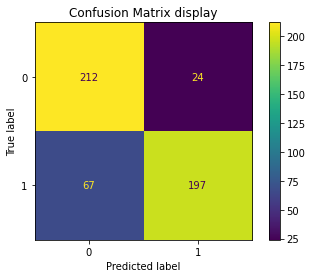

In [126]:
# Show the results in a readable format
# Confusion Matrix
CM = confusion_matrix(val_labels, y_pred)
print('Confusion Matrix: \n {}'.format(CM)+"\n")

# Confusion Matrix display
display = ConfusionMatrixDisplay(confusion_matrix=CM, display_labels=multinomial_model.classes_)
display.plot()
plt.title("Confusion Matrix display")

# Classification report
print(classification_report(val_labels, y_pred))

On peut jeter un oeil aux *features* construites par le ```vectorizer```. Comment pourrait-on les améliorer ? 

In [115]:
print(vectorizer.get_feature_names()[:100])

['00', '000', '00001', '007', '0079', '0080', '0083', '01', '02', '05', '06', '07', '08', '10', '100', '1000', '1000000', '100m', '101', '102', '103', '105', '10th', '10yr', '11', '110', '1100', '112', '12', '120', '1200f', '123', '125', '12s', '12th', '13', '130', '13th', '14', '15', '150', '16', '1692', '16th', '17', '1700', '1794', '1798', '17th', '18', '180', '1800', '1814', '1824', '1840', '1840s', '1850', '1864', '1880', '1880s', '1889', '1892', '1895', '1897', '18th', '19', '1902', '1907', '1910', '1911', '1912', '1914', '1916', '1918', '1919', '1920', '1920s', '1921', '1922', '1924', '1925', '1927', '1928', '1929', '1930', '1930s', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1940s', '1941', '1942', '1943']


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Améliorer les représentations BoW

Les arguments du ```vectorizer``` vont nous permettre d'agir facilement sur la façon dont les données sont représentées. On peut donc chercher à améliorer nos représentations *Bag-of-words*:

#### Ne pas prendre en compte les mots trop fréquents:

On peut utiliser l'option ```max_df=1.0``` pour modifier la quantité de mots pris en compte. 

#### Essayer différentes granularités:

Plutôt que de simplement compter les mots, on peut compter les séquences de mots - de taille limitée, bien sur. 
On appelle une séquence de $n$ mots un $n$-gram: essayons d'utiliser les 2 et 3-grams (bi- et trigrams).
On peut aussi tenter d'utiliser les séquences de caractères à la place de séquences de mots.

On s'intéressera aux options ```analyzer='word'``` et ```ngram_range=(1, 2)``` que l'on changera pour modifier la granularité. 

**Encore une fois: avoir recours à ces features aura probablement plus d'impact si la quantité de données d'entraînement à notre disposition est limitée !**

Pour accélérer les expériences, utilisez l'outil ```Pipeline``` de scikit-learn. 

In [116]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [117]:
# Create a pipeline for each configuration


pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        
        ("clf", MultinomialNB())
    ]
)

parameters = {
    "vect__max_df": (1, 2, 3),
    "vect__analyzer" : ['word'],
    "vect__ngram_range": ((1,1),(1,2),(2,2),(1,3),(2,3),(3,3))  
    
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

grid_search.fit(train_texts_splt, train_labels_splt)
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))



Performing grid search...
pipeline: ['vect', 'clf']
parameters:
{'vect__max_df': (1, 2, 3), 'vect__analyzer': ['word'], 'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3))}
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best score: 0.750
Best parameters set:
	vect__analyzer: 'word'
	vect__max_df: 3
	vect__ngram_range: (2, 3)


In [118]:
y_pred = grid_search.predict(val_texts)
print("model score for test features : %0.3f" % grid_search.score(val_texts, val_labels))

model score for test features : 0.752


#### Tf-idf:

Il s'agit du produit de la fréquence du terme (TF) et de sa fréquence inverse dans les documents (IDF).
Cette méthode est habituellement utilisée pour extraire l'importance d'un terme $i$ dans un document $j$ relativement au reste du corpus, à partir d'une matrice d'occurences $mots \times documents$. Ainsi, pour une matrice $\mathbf{T}$ de $|V|$ termes et $D$ documents:
$$\text{TF}(T, w, d) = \frac{T_{w,d}}{\sum_{w'=1}^{|V|} T_{w',d}} $$

$$\text{IDF}(T, w) = \log\left(\frac{D}{|\{d : T_{w,d} > 0\}|}\right)$$

$$\text{TF-IDF}(T, w, d) = \text{TF}(X, w, d) \cdot \text{IDF}(T, w)$$

On peut l'adapter à notre cas en considérant que le contexte du deuxième mot est le document. Cependant, TF-IDF est généralement plus adaptée aux matrices peu denses, puisque cette mesure pénalisera les termes qui apparaissent dans une grande partie des documents. 

In [119]:
from sklearn.feature_extraction.text import TfidfTransformer

In [120]:
pipeline = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
        ("clf", MultinomialNB())
    ]
)

parameters = {
    "vect__max_df": (1, 2, 3),
    "vect__analyzer" : ['word'],
    "vect__ngram_range": ((1,1),(1,2),(2,2),(1,3),(2,3),(3,3))  
    
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)

grid_search.fit(train_texts_splt, train_labels_splt)
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (1, 2, 3), 'vect__analyzer': ['word'], 'vect__ngram_range': ((1, 1), (1, 2), (2, 2), (1, 3), (2, 3), (3, 3))}
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best score: 0.742
Best parameters set:
	vect__analyzer: 'word'
	vect__max_df: 3
	vect__ngram_range: (2, 3)


In [121]:
y_pred = grid_search.predict(val_texts)
print("model score for test features : %0.3f" % grid_search.score(val_texts, val_labels))

model score for test features : 0.724


### Outils de prétraitement: NLTK

On va maintenant chercher à pré-traiter nos données de manière à simplifier la tâche du modèle. **Notez toujours que celà ne sera probablement utile que si l'on a trop peu de données à disposition !**

#### Stemming: 

Permet de revenir à la racine d'un mot: on peut ainsi grouper différents mots autour de la même racine, ce qui facilite la généralisation. On peut utiliser l'outil ```SnowballStemmer```.

In [32]:
from nltk import SnowballStemmer
stemmer = SnowballStemmer("english")

Exemple d'utilisation:

In [33]:
words = ['singers', 'cat', 'generalization', 'philosophy', 'psychology', 'philosopher']
for word in words:
    print('word : %s ; stemmed : %s' %(word, stemmer.stem(word)))#.decode('utf-8'))))

word : singers ; stemmed : singer
word : cat ; stemmed : cat
word : generalization ; stemmed : general
word : philosophy ; stemmed : philosophi
word : psychology ; stemmed : psycholog
word : philosopher ; stemmed : philosoph


Transformation des données:

In [34]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize


sentence = ['I am going to school tomorrow']

for word in sentence:
  words = word_tokenize(word)
  for i in words:
      print('word : %s ; stemmed : %s' %(i, stemmer.stem(i)))#.decode('utf-8'))))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


word : I ; stemmed : i
word : am ; stemmed : am
word : going ; stemmed : go
word : to ; stemmed : to
word : school ; stemmed : school
word : tomorrow ; stemmed : tomorrow


In [35]:
def stem(X): 
  for word in X:
    words = word_tokenize(word)
    for i in words:
      print('word : %s ; stemmed : %s' %(i, stemmer.stem(i)))#.decode('utf-8'))))


In [36]:
# Test it on the dataset
stem(train_texts_reduced)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
word : series ; stemmed : seri
word : '' ; stemmed : ''
word : delivers ; stemmed : deliv
word : great ; stemmed : great
word : fun ; stemmed : fun
word : , ; stemmed : ,
word : nasty ; stemmed : nasti
word : gore ; stemmed : gore
word : and ; stemmed : and
word : gratuitous ; stemmed : gratuit
word : shocks ; stemmed : shock
word : and ; stemmed : and
word : `` ; stemmed : ``
word : Zombi ; stemmed : zombi
word : 3 ; stemmed : 3
word : '' ; stemmed : ''
word : is ; stemmed : is
word : no ; stemmed : no
word : exception ; stemmed : except
word : to ; stemmed : to
word : this ; stemmed : this
word : , ; stemmed : ,
word : despite ; stemmed : despit
word : all ; stemmed : all
word : the ; stemmed : the
word : production ; stemmed : product
word : difficulties ; stemmed : difficulti
word : that ; stemmed : that
word : occurred ; stemmed : occur
word : whilst ; stemmed : whilst
word : shooting ; stemmed : shoot
w

#### Partie du discours

Pour généraliser, on peut aussi utiliser les parties du discours (Part of Speech, POS) des mots, ce qui nous permettra  de filtrer l'information qui n'est potentiellement pas utile au modèle. On va récupérer les POS des mots à l'aide des fonctions ```pos_tag, word_tokenize```.

In [37]:
import nltk
from nltk import pos_tag, word_tokenize

Exemple d'utilisation:

In [38]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

pos_tag(word_tokenize(('I am Sam')))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


[('I', 'PRP'), ('am', 'VBP'), ('Sam', 'NNP')]

Transformation des données:

Ne garder que les noms, adverbes, verbes et adjectifs (```['NN', 'VB', 'ADJ', 'RB']```) pour notre modèle. 

In [39]:
def pos_tag_filter(X, good_tags=['NN', 'VB', 'ADJ', 'RB']):
    pos = []
    for text in X:
        tags = nltk.pos_tag(nltk.word_tokenize(text))
        pos.append(' '.join([w for w, t in tags if t in good_tags]))
    return pos

In [40]:
# Test it on the dataset
text_filtered = pos_tag_filter(train_texts_reduced)

In [41]:
text_filtered

['Story man pig opening scene example comedy orchestra audience insane mob Unfortunately time eventually just too Even era be dialogue make seem grader level think cinematography be briefly',
 "film giant pant load utterly screenplay directing as comatose be actually process br though cast walker man companion elite n't have dimensional magazine front camera popsicle stick accent rack version beginning end line heat humidity still ounce energy not accent movie boyfriend affect kind accent so barely deliver r spite fact life kind reason cast someone else n't ya think br br > story screenplay directing camera work movie end film Only make movie dignity tact fact spite really film Ufortunately one ever be enough redeem series watch something else movie not time",
 'script waste',
 'action movie bhai comedy not see anything film story writer son write movie so long range shotgun director make movie money movie not recommend anybody give give zero',
 "Sometime understand movie trauma again 

## Fine-tuning d'un modèle Bert

Suivant le modèle du TP précédent, fine-tunez le modèle Bert le plus léger disponible sur les données d'IMDB et comparez avec les résultats obtenus précédemment. **Encore une fois, si possible, réalisez cette étude pour des quantités de données différentes.**

In [42]:
import transformers
!pip install fasttext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 68 kB 4.9 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3146445 sha256=e021c3a1fb4b6de09acd1ad7e39f4b23230ef1906934295da7967c79f51ddc5f
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [43]:
import numpy as np
import fasttext
import torch
from transformers import DistilBertTokenizerFast, DistilBertModel, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments

from sklearn import neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

import pandas as pd
import altair as alt

import pprint
pp = pprint.PrettyPrinter(indent=4)

In [44]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [45]:
def load_data(text, label):
    examples = []
    for line, line_n in zip(text, label):
        tokens = line.split('\t')
        tokens = tokens[0].split()
        examples.append({'tokens': tokens, 'class': int(line_n)})

    return examples

In [46]:
class FineTuningDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [55]:
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  acc = accuracy_score(labels, preds)
  return {
      'accuracy': acc,
  }

**k= 10**

In [92]:
k = 10
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Nombre de documents:', len(train_texts_reduced))

Nombre de documents: 2500


In [93]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

In [94]:
imdb_train = load_data(train_texts_splt, train_labels_splt)

imdb_test = load_data(val_texts, val_labels)

In [95]:
# First, encode training and testing data. Note that we do it for the full dataset at once, this time.
imdb_inputs = tokenizer([' '.join(ex['tokens']) for ex in imdb_train],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")

imdb_test_inputs = tokenizer([' '.join(ex['tokens']) for ex in imdb_test],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")


In [96]:
imdb_train_classes = [ex['class'] for ex in imdb_train]

imdb_test_classes = [ex['class'] for ex in imdb_test]

In [98]:
imdb_dataset = FineTuningDataset(imdb_inputs, imdb_train_classes)
imdb_test_dataset = FineTuningDataset(imdb_test_inputs, imdb_test_classes)

In [99]:
imdb_model_ft = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= max(imdb_train_classes) + 1).to("cuda")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [100]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [101]:
imdb_trainer = Trainer(
    model=imdb_model_ft,                      
    args=training_args,                  
    train_dataset=imdb_dataset,         
    eval_dataset=imdb_test_dataset,           
    compute_metrics=compute_metrics       
)

In [102]:
imdb_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 2000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 375
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss,Accuracy
100,0.556500,0.339967,0.860000
200,0.270400,0.389358,0.878000
300,0.205700,0.352665,0.904000


***** Running Evaluation *****
  Num examples = 500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
***** Running Evaluation *****
  Num examples = 500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor

TrainOutput(global_step=375, training_loss=0.2990331064860026, metrics={'train_runtime': 303.9131, 'train_samples_per_second': 19.742, 'train_steps_per_second': 1.234, 'total_flos': 794804391936000.0, 'train_loss': 0.2990331064860026, 'epoch': 3.0})

In [69]:
score_k_10 = imdb_trainer.evaluate()
score_k_10


***** Running Evaluation *****
  Num examples = 500
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'epoch': 3.0,
 'eval_accuracy': 0.872,
 'eval_loss': 0.4700281023979187,
 'eval_runtime': 7.7153,
 'eval_samples_per_second': 64.806,
 'eval_steps_per_second': 3.24}

**k= 100**

In [70]:
k = 100
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Nombre de documents:', len(train_texts_reduced))

Nombre de documents: 250


In [71]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

In [72]:
imdb_train = load_data(train_texts_splt, train_labels_splt)

imdb_test = load_data(val_texts, val_labels)

In [73]:
# First, encode training and testing data. Note that we do it for the full dataset at once, this time.
imdb_inputs = tokenizer([' '.join(ex['tokens']) for ex in imdb_train],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")

imdb_test_inputs = tokenizer([' '.join(ex['tokens']) for ex in imdb_test],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")


In [74]:
imdb_train_classes = [ex['class'] for ex in imdb_train]

imdb_test_classes = [ex['class'] for ex in imdb_test]

In [75]:
imdb_dataset = FineTuningDataset(imdb_inputs, imdb_train_classes)
imdb_test_dataset = FineTuningDataset(imdb_test_inputs, imdb_test_classes)

In [76]:
imdb_model_ft = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= max(imdb_train_classes) + 1).to("cuda")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [77]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [78]:
imdb_trainer = Trainer(
    model=imdb_model_ft,                      
    args=training_args,                  
    train_dataset=imdb_dataset,         
    eval_dataset=imdb_test_dataset,           
    compute_metrics=compute_metrics       
)

In [79]:
imdb_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 200
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 39
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=39, training_loss=0.6637856410099909, metrics={'train_runtime': 27.3955, 'train_samples_per_second': 21.901, 'train_steps_per_second': 1.424, 'total_flos': 79480439193600.0, 'train_loss': 0.6637856410099909, 'epoch': 3.0})

In [80]:
score_k_100 = imdb_trainer.evaluate()
score_k_100


***** Running Evaluation *****
  Num examples = 50
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'epoch': 3.0,
 'eval_accuracy': 0.82,
 'eval_loss': 0.5622288584709167,
 'eval_runtime': 0.8249,
 'eval_samples_per_second': 60.615,
 'eval_steps_per_second': 3.637}

**k= 1000**

In [81]:
k = 1000
train_texts_reduced = train_texts[0::k]
train_labels_reduced = train_labels[0::k]

print('Nombre de documents:', len(train_texts_reduced))

Nombre de documents: 25


In [82]:
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(train_texts_reduced, train_labels_reduced, test_size=.2)

In [83]:
imdb_train = load_data(train_texts_splt, train_labels_splt)

imdb_test = load_data(val_texts, val_labels)

In [84]:
# First, encode training and testing data. Note that we do it for the full dataset at once, this time.
imdb_inputs = tokenizer([' '.join(ex['tokens']) for ex in imdb_train],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")

imdb_test_inputs = tokenizer([' '.join(ex['tokens']) for ex in imdb_test],
                              truncation=True,
                              padding='max_length', 
                              return_tensors="pt")


In [85]:
imdb_train_classes = [ex['class'] for ex in imdb_train]

imdb_test_classes = [ex['class'] for ex in imdb_test]

In [86]:
imdb_dataset = FineTuningDataset(imdb_inputs, imdb_train_classes)
imdb_test_dataset = FineTuningDataset(imdb_test_inputs, imdb_test_classes)

In [87]:
imdb_model_ft = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels= max(imdb_train_classes) + 1).to("cuda")

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a73936dd2b627e42851bec0831212b677c637033ee4bce9

In [88]:
training_args = TrainingArguments(
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=20,   # batch size for evaluation
    learning_rate=5e-5,              # initial learning rate for Adam optimizer
    warmup_steps=100,                # number of warmup steps for learning rate scheduler (set lower because of small dataset size)
    weight_decay=0.01,               # strength of weight decay
    output_dir='./results',          # output directory
    logging_dir='./logs',            # directory for storing logs
    logging_steps=100,               # number of steps to output logging (set lower because of small dataset size)
    evaluation_strategy='steps',     # evaluate during fine-tuning so that we can see progress
)

using `logging_steps` to initialize `eval_steps` to 100
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [89]:
imdb_trainer = Trainer(
    model=imdb_model_ft,                      
    args=training_args,                  
    train_dataset=imdb_dataset,         
    eval_dataset=imdb_test_dataset,           
    compute_metrics=compute_metrics       
)

In [90]:
imdb_trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6, training_loss=0.6998394330342611, metrics={'train_runtime': 2.7731, 'train_samples_per_second': 21.636, 'train_steps_per_second': 2.164, 'total_flos': 7948043919360.0, 'train_loss': 0.6998394330342611, 'epoch': 3.0})

In [91]:
score_k_1000 = imdb_trainer.evaluate()
score_k_1000


***** Running Evaluation *****
  Num examples = 5
  Batch size = 20
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


{'epoch': 3.0,
 'eval_accuracy': 0.6,
 'eval_loss': 0.6854230761528015,
 'eval_runtime': 0.1578,
 'eval_samples_per_second': 31.679,
 'eval_steps_per_second': 6.336}

# Conclusion

**Results**

| Number of Documents  | Multinomial with Pipeline |Multinomial with Pipeline & Tf-idf | Bert Model |
|-----------|-----------|-----------|-----------|
| k = 10| 0.752 | 0.724 | 0.872 |
| k = 100| No run |No run| 0.820|
| k = 1000| No run | No run| 0.600|

The Bert Model gets the best score prediction when we train the model with enough documents. For k=1000, we get 25 documents, the Bert model does not provide a good prediction score, hence why the number of document is an important parameter.  